# **A Case Analysis of Airbnb 2021 Listings on Hawaii, Hawaii**

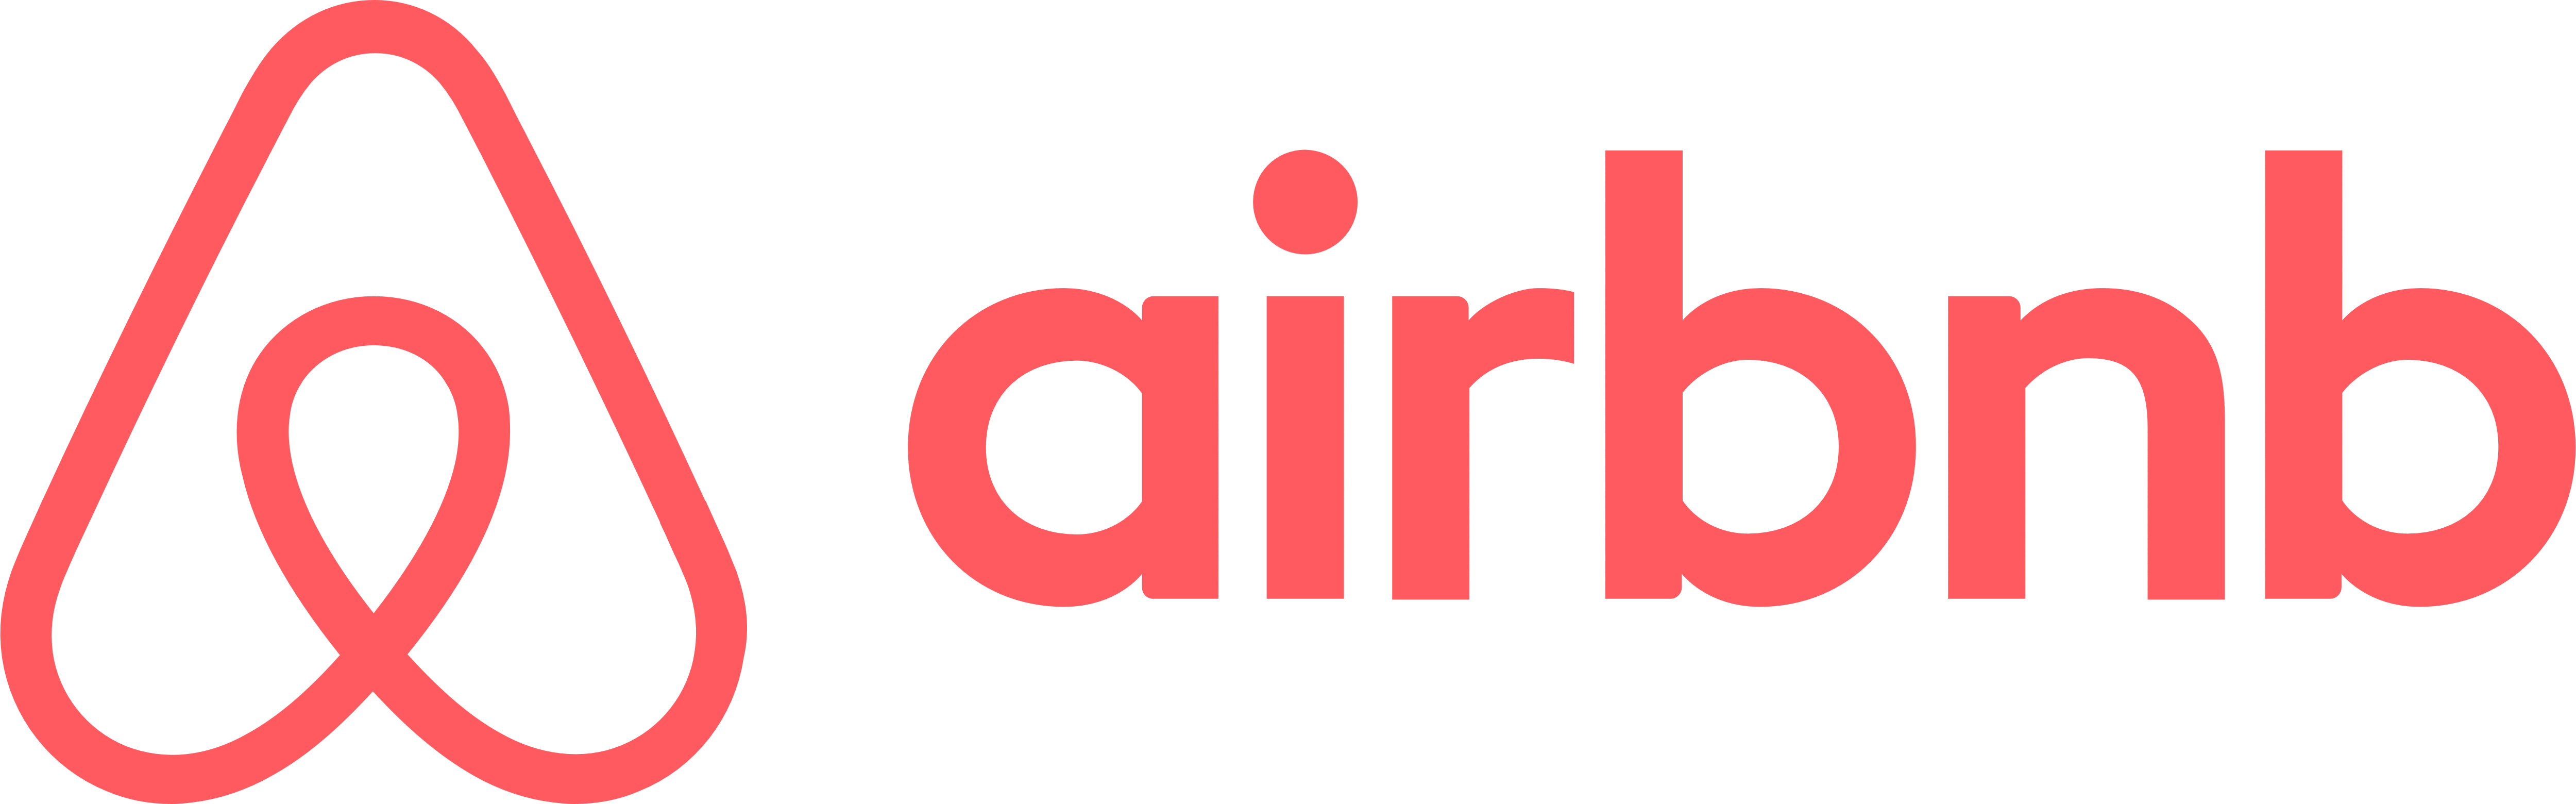

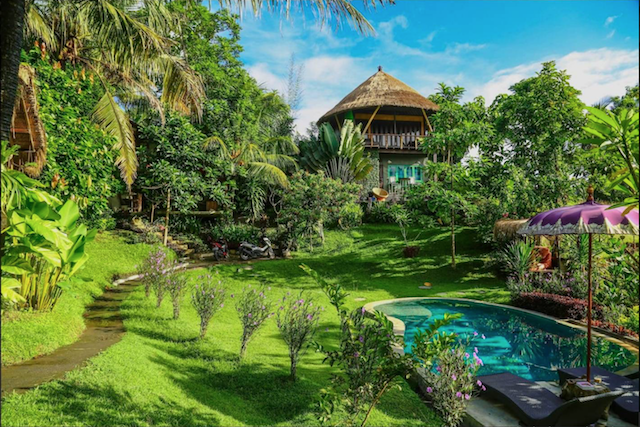

Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. However, the scope in in this case analysis are only from December 2020 to December 2021. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in Hawaii, Hawaii.

## **Loading Files**

Data Source: http://insideairbnb.com/get-the-data.html

In [1]:
import requests
import os
import zipfile as zp
import gzip
import pandas as pd
import csv
import shutil
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
!git clone https://github.com/eliasezar27/PRESANA.git

fatal: destination path 'PRESANA' already exists and is not an empty directory.


In [3]:
base_dir = '/content/PRESANA/hawaii_airBnbGroup'

calendar_csv1 = os.path.join(base_dir, 'calendar_main_part1.csv')
calendar_csv2 = os.path.join(base_dir, 'calendar_main_part2.csv')
calendar_csv3 = os.path.join(base_dir, 'calendar_main_part3.csv')
calendar_csv4 = os.path.join(base_dir, 'calendar_main_part4.csv')

listings_csv = os.path.join(base_dir, 'listings_main.csv')

covid_csv = os.path.join(base_dir, 'hawaii_covid_cases.csv')

### **AirBnb Listings Descriptions**

In [4]:
listings = pd.read_csv(listings_csv)
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31450 entries, 0 to 31449
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            31450 non-null  int64  
 1   listing_url                                   31450 non-null  object 
 2   scrape_id                                     31450 non-null  int64  
 3   last_scraped                                  31450 non-null  object 
 4   name                                          31450 non-null  object 
 5   description                                   31077 non-null  object 
 6   neighborhood_overview                         17223 non-null  object 
 7   picture_url                                   31450 non-null  object 
 8   host_id                                       31450 non-null  int64  
 9   host_url                                      31450 non-null 

### **AirBnb Listings History**

In [5]:
calendar_df1 = pd.read_csv(calendar_csv1, parse_dates=['date'])
calendar_df2 = pd.read_csv(calendar_csv2, parse_dates=['date'])
calendar_df3 = pd.read_csv(calendar_csv3, parse_dates=['date'])
calendar_df4 = pd.read_csv(calendar_csv4, parse_dates=['date'])

calendar  = pd.concat([calendar_df1, calendar_df2, calendar_df3, calendar_df4])

print('Calendar dataframe Information:\n')
calendar.info()

Calendar dataframe Information:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9300867 entries, 0 to 2325215
Data columns (total 4 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   adjusted_price  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 354.8+ MB


### **Hawaii Covid Cases**

In [6]:
covid_cases = pd.read_csv(covid_csv, parse_dates=['date'])
covid_cases['cumsum'] = covid_cases['total'].cumsum()
covid_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      641 non-null    datetime64[ns]
 1   hawaii    641 non-null    int64         
 2   honolulu  641 non-null    int64         
 3   maui      641 non-null    int64         
 4   kauai     641 non-null    int64         
 5   total     641 non-null    int64         
 6   cumsum    641 non-null    int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 35.2 KB


## **Data Cleanup and Preprocessing**

### **AirBnb Listings Descriptions**

In [7]:
print('Look for null values in the dataframe per column\n')

col_nans = listings.isnull().sum()[listings.isnull().sum() > 0].index.values # Saving all columns names with nan values into a variable
listings.isnull().sum()[listings.isnull().sum() > 0]

Look for null values in the dataframe per column



description                      373
neighborhood_overview          14227
host_name                        199
host_since                       199
host_location                    235
host_about                      9329
host_response_time              4644
host_response_rate              4644
host_acceptance_rate            3974
host_is_superhost                199
host_thumbnail_url               199
host_picture_url                 199
host_neighbourhood              5190
host_listings_count              199
host_total_listings_count        199
host_has_profile_pic             199
host_identity_verified           199
neighbourhood                  14227
bathrooms                      31450
bathrooms_text                    40
bedrooms                        4404
beds                             104
minimum_minimum_nights             1
maximum_minimum_nights             1
minimum_maximum_nights             1
maximum_maximum_nights             1
minimum_nights_avg_ntm             1
m

In [8]:
# Listing price that are $0.00 and their host name

listings[listings['price'] == 0][['id', 'host_name', 'price']]

id                           host_name  price
20014  41740619                    Alohilani Resort    0.0
21146  43309266                       Hilo Hawaiian    0.0
25167  47816777  Waipouli Beach Resort By Outrigger    0.0

In [9]:
# View other listings with same host name with listings priced at $0.00

print('Total istings with host name: Alohilani Resort ', listings[listings['host_name'] == 'Alohilani Resort']['host_name'].count())
print('Total istings with host name: Hilo Hawaiian ', listings[listings['host_name'] == 'Hilo Hawaiian']['host_name'].count())
print('Total istings with host name: Waipouli Beach Resort By Outrigger ', listings[listings['host_name'] == 'Waipouli Beach Resort By Outrigger']['host_name'].count())

Total istings with host name: Alohilani Resort  11
Total istings with host name: Hilo Hawaiian  15
Total istings with host name: Waipouli Beach Resort By Outrigger  1


In [10]:
# Fill $0.00 priced listing with the median price from the listings that belongs to the same host name

mask1 = listings['id'] == 41740619
mask2 = listings['id'] == 43309266

listings['price'] = listings['price'].mask(mask1, float(listings[listings['host_name'] == 'Alohilani Resort']['price'].median()))
listings['price'] = listings['price'].mask(mask2, float(listings[listings['host_name'] == 'Hilo Hawaiian']['price'].median()))

# Drop listing with $0.00 price and no similar host name

listings = listings.drop([listings.index[listings['id'] == 47816777][0]])

In [11]:
# Dropping columns containing any nan values

listings.drop(columns=col_nans, inplace=True)
listings.dropna(1, inplace=True)

In [12]:
listings.describe().transpose()

count  ...           max
id                                            31449.0  ...  5.272250e+07
scrape_id                                     31449.0  ...  2.021101e+13
host_id                                       31449.0  ...  4.256547e+08
latitude                                      31449.0  ...  2.222898e+01
longitude                                     31449.0  ... -1.548229e+02
accommodates                                  31449.0  ...  1.600000e+01
price                                         31449.0  ...  2.500000e+04
minimum_nights                                31449.0  ...  3.650000e+02
maximum_nights                                31449.0  ...  1.825000e+03
availability_30                               31449.0  ...  3.000000e+01
availability_60                               31449.0  ...  6.000000e+01
availability_90                               31449.0  ...  9.000000e+01
availability_365                              31449.0  ...  3.650000e+02
number_of_reviews                             31449.0  ...  8.470000e+02
number_of_reviews_ltm                         31449.0  ...  3.720000e+02
number_of_reviews_l30d                        31449.0  ...  2.700000e+01
calculated_host_listings_count                31449.0  ...  4.800000e+02
calculated_host_listings_count_entire_homes   31449.0  ...  4.800000e+02
calculated_host_listings_count_private_rooms  31449.0  ...  1.440000e+02
calculated_host_listings_count_shared_rooms   31449.0  ...  6.000000e+00

[20 rows x 8 columns]

### **AirBnb Listings History**

In [13]:
print('Look for null values in the dataframe per column\n')

calendar.isnull().sum()

Look for null values in the dataframe per column



listing_id          0
date                0
available           0
adjusted_price    287
dtype: int64

In [14]:
# Fill null in adjusted price column with the price based on the listing price in the listings dataframe.

for i in calendar[calendar['adjusted_price'].isnull()]['listing_id'].unique():
    mask = calendar['listing_id'] == i
    rep_val = listings[listings['id'] == i]['price'].values[0]
    calendar['adjusted_price'] = calendar['adjusted_price'].mask(mask, calendar['adjusted_price'].fillna(rep_val))

In [15]:
# Fill $0.00 in adjusted price column with the price based on the listing price in the listings dataframe.

for i in calendar[calendar['adjusted_price'] == 0]['listing_id'].unique():
    mask = calendar['listing_id'] == i
    rep_val = listings[listings['id'] == i]['price'].values[0]
    calendar['adjusted_price'] = calendar['adjusted_price'].mask(mask, rep_val)

In [16]:
# Transform categorical available column into numeric where 'f' is 1 and 't' is 0
calendar['occupied'] = calendar['available'].map({'f': 1, 't': 0})

In [17]:
calendar.rename(columns={'listing_id':'id'}, inplace=True)
calendar = pd.merge(calendar, 
                    listings[['id', 'name', 'neighbourhood_group_cleansed', 'longitude', 'latitude']], 
                    on='id', how='left')
calendar.rename(columns={'neighbourhood_group_cleansed':'county'}, inplace=True)
calendar.rename(columns={'adjusted_price':'price'}, inplace=True)

In [18]:
# Sort calendar dataframe based on date from oldest to latest
calendar = calendar.sort_values(['date', 'id'])

# View the oldest and latest listing history
print("Historical Listings are from:", pd.to_datetime(calendar.date).min(), 'to', pd.to_datetime(calendar.date).max())

Historical Listings are from: 2020-12-19 00:00:00 to 2021-12-03 00:00:00


In [19]:
calendar.describe().transpose()

count          mean  ...           75%           max
id         9300867.0  3.011329e+07  ...  4.335773e+07  5.272250e+07
price      9300867.0  3.917758e+02  ...  3.570000e+02  2.500000e+04
occupied   9300867.0  6.744477e-01  ...  1.000000e+00  1.000000e+00
longitude  9300867.0 -1.571384e+02  ... -1.564401e+02 -1.548229e+02
latitude   9300867.0  2.088986e+01  ...  2.128777e+01  2.222898e+01

[5 rows x 8 columns]

In [20]:
# Dataframe for aggregated occupied listing tally and median price per date
calendar_day = calendar.groupby('date', as_index=False)['occupied'].sum()
calendar_day = pd.merge(calendar_day, calendar.groupby('date', as_index=False)['price'].median(),
                             on='date', how='left')

# Dataframe for aggregated occupied listing tally and median price per county per date
calendar_county = calendar.groupby(['county', 'date'], as_index=False)['occupied'].sum()
calendar_county = pd.merge(calendar_county, 
                           calendar.groupby(['county', 'date'], as_index=False)['price'].median(), 
                           on=['county', 'date'], how='left')

# Dataframe with aggregated occupied listing tally per id listing
calendar_id = calendar.groupby(['id'], as_index=False)['occupied'].sum()
calendar_id = pd.merge(calendar_id, 
                       listings[['id', 'name', 'neighbourhood_group_cleansed', 'longitude', 'latitude', 'price']], 
                       on='id', how='left').drop_duplicates('id').reset_index(drop=True)
calendar_id.rename(columns={'neighbourhood_group_cleansed':'county'}, inplace=True)

## **Descriptive Analytics**

In [21]:
fig = px.scatter_mapbox(calendar_id, lat="latitude", lon="longitude",
                        hover_name="name", hover_data=["price", "occupied"],
                        color="county", zoom=6.9, height=600)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(legend=dict(
                                yanchor="top",
                                y=0.99,
                                xanchor="left",
                                x=0.01
                            ))
fig.show()

In [22]:
fig = px.bar(calendar_id[['name', 'price', 'county']].sort_values(['price']).head(10), 
             x="price", y="name", orientation='h', hover_name='county',
             title='Top 10 Afordable Listing')
fig.show()

In [23]:
fig = px.histogram(calendar_id, x="price",
                   labels={'price': 'Price ($)'}, color='county',
                   title='Distribution of Listing Price in Hawaii State')
fig.show()

In [24]:
fig = px.box(listings, x="room_type", y="price",
             labels={'price': 'Price ($)', 'room_type': 'Room Type'},
             title='Listing Prices per Room type', color='room_type')
fig.update_layout(legend=dict(
                                yanchor="top",
                                y=0.99,
                                xanchor="right",
                                x=.99
                            ))
fig.show()

In [25]:
fig = px.line(calendar_county, x="date", y="price", 
              title='Side by Side comparison of Listing Prices per County', color='county',
              labels={'price': 'Median Prices ($)'})
fig.show()

In [26]:
fig = px.line(calendar_county, x="date", y="occupied", 
              title='Side by Side comparison of Occupied Listings per County', color='county',
              labels={'occupied': 'Total Listings Occupied'})
fig.update_layout(legend=dict(
                                yanchor="top",
                                y=0.99,
                                xanchor="left",
                                x=.01
                            ))
fig.show()

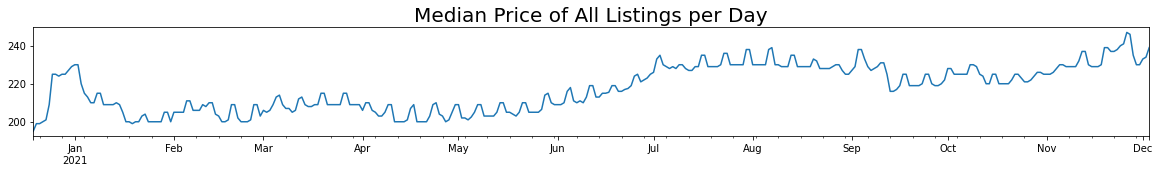

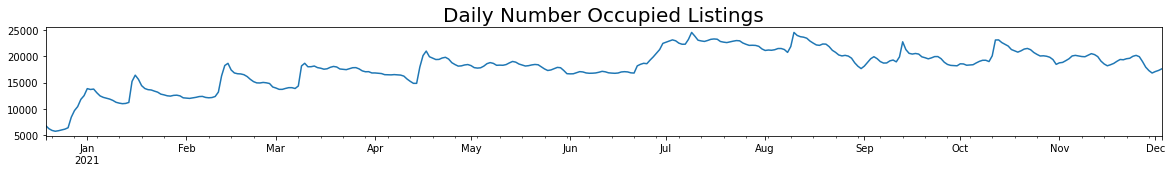

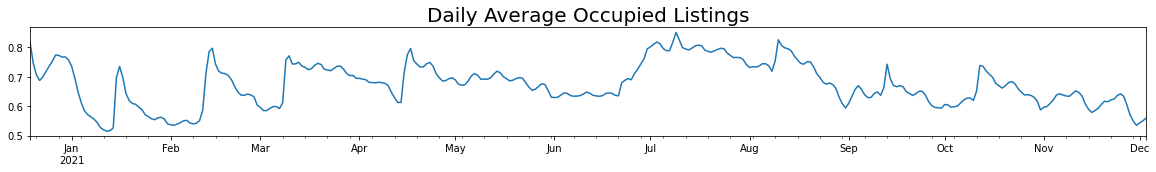

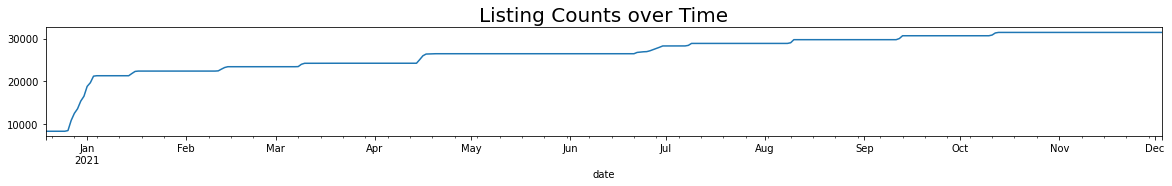

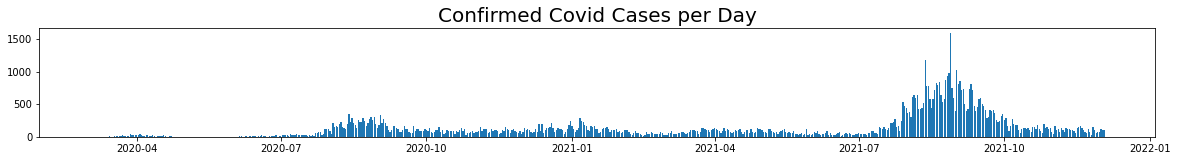

In [27]:
plt.figure(figsize=(20,2))
plt.title('Median Price of All Listings per Day', fontdict={'fontsize': 20})
calendar_day.groupby('date')['price'].median().plot()
plt.xlabel(None)
plt.show()


plt.figure(figsize=(20,2))
plt.title('Daily Number Occupied Listings', fontdict={'fontsize': 20})
calendar.groupby('date')['occupied'].sum().plot()
plt.xlabel(None)
plt.show()

plt.figure(figsize=(20,2))
plt.title('Daily Average Occupied Listings', fontdict={'fontsize': 20})
calendar.groupby('date')['occupied'].mean().plot()
plt.xlabel(None)
plt.show()

plt.figure(figsize=(20,2))
plt.title('Listing Counts over Time', fontdict={'fontsize': 20})
calendar.groupby('date')['occupied'].count().plot()
plt.show()

plt.figure(figsize=(20,2))
plt.title('Confirmed Covid Cases per Day', fontdict={'fontsize': 20})
plt.bar(covid_cases['date'], covid_cases['total'])
plt.show()

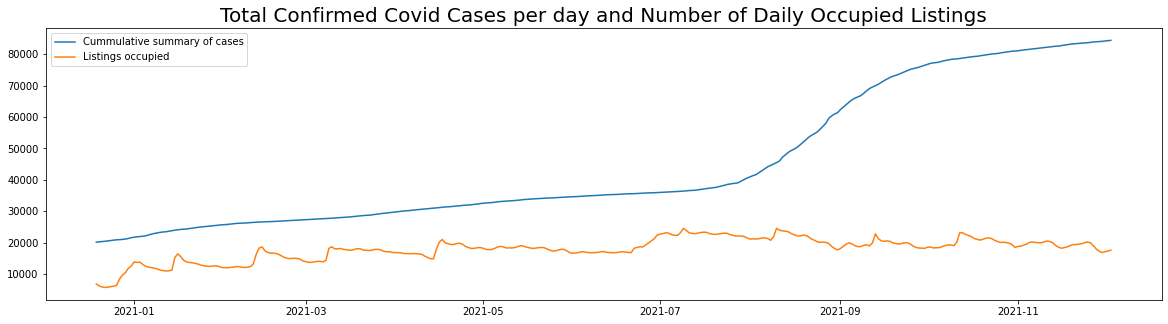

In [28]:
covid_cases2 = covid_cases[covid_cases['date'] >= calendar['date'].min()][['date', 'total', 'cumsum']]

plt.figure(figsize=(20,5))
plt.title('Total Confirmed Covid Cases per day and Number of Daily Occupied Listings', fontdict={'fontsize': 20})
plt.plot(covid_cases2['date'], covid_cases2['cumsum'], label='Cummulative summary of cases')
plt.plot(calendar_day.groupby('date')['occupied'].sum(), label='Listings occupied')
plt.legend()
plt.show()

In [29]:
fig = px.scatter(calendar_day, 
                 x="occupied", y="price", 
                 title='Daily Number of Occupied Listings vs Median Price of Listings per Day',
                 labels={'price': 'Median Prices ($)', 'occupied': 'Total Listings Occupied'})
fig.show()

## **Predictive Analytics**

### Regression Model for Daily Number of Occupied listing vs Median Price Listings per Day

In [30]:
calendar_day[['occupied', 'price']].corr("pearson")

occupied     price
occupied  1.000000  0.570847
price     0.570847  1.000000

Exactly –1. A perfect downhill (negative) linear relationship

–0.70. A strong downhill (negative) linear relationship

–0.50. A moderate downhill (negative) relationship

–0.30. A weak downhill (negative) linear relationship

0. No linear relationship

+0.30. A weak uphill (positive) linear relationship

+0.50. A moderate uphill (positive) relationship

+0.70. A strong uphill (positive) linear relationship

Exactly +1. A perfect uphill (positive) linear relationship

In [31]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
y = calendar_day[['price']]
x = calendar_day[['occupied']]

lr_model = lr.fit(x, y)

r_sq = lr_model.score(x, y)
print('coefficient of determination:', r_sq)


coefficient of determination: 0.3258657600799819


In [32]:
fig = px.scatter(calendar_day, 
                 x="occupied", y="price", 
                 title='Daily Number of Occupied Listings vs Median Price of Listings per Day', 
                 trendline='ols', trendline_color_override='red',
                 labels={'price': 'Median Prices ($)', 'occupied': 'Total Listings Occupied'})
fig.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



### ARIMA for Median Price Listings per Day

In [33]:
calendar_day.index = calendar_day['date']
calendar_day = calendar_day.asfreq('d')

In [34]:
from statsmodels.tsa.stattools import adfuller

def adfTest(data):
    print('H0: Data is non-stationary')
    print('Ha: Data is stationary \n')
    dec = {1: 'fail to reject', 2: 'reject', 3: 'Non-stationary', 4: 'Stationary'}
    X = data
    result = adfuller(X, maxlag=13, autolag='BIC')
    print('ADF Statistic/ Test Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('No. of lags: %d' % result[2])
    print('Num of obs: %d' % result[3])
    print('Critical Values:')
    for key, value in result[4].items():
        con = dec[2] if result[0] < value else dec[1]
        print('\t%s: %.3f, therefore,' % (key, value), con, 'null hypothesis')
    
    print('\nFor a 5% critical value, the data is', dec[3] if con == dec[1] else dec[4])  

H0: Data is non-stationary

Ha: Data is stationary 

if Test Statistic < Critical Values => Rejects the null hypothesis.

if Test Statistic > Critical Values => failed to reject the null hypothesis.

In [35]:
adfTest(calendar_day['price'])

H0: Data is non-stationary
Ha: Data is stationary 

ADF Statistic/ Test Statistic: -0.879546
p-value: 0.794634
No. of lags: 10
Num of obs: 339
Critical Values:
	1%: -3.450, therefore, fail to reject null hypothesis
	5%: -2.870, therefore, fail to reject null hypothesis
	10%: -2.571, therefore, fail to reject null hypothesis

For a 5% critical value, the data is Non-stationary


In [36]:
def globVSloc(data):
    from math import sqrt
    # Cochran's Sample Size
    n0 = int(((1.96)**2 * (0.5) * (1 - 0.5)) / (0.05)**2)
    n = int(n0 /(1+(( n0 - 1 )/ len(data) )))

    dec_mean = {1: 'Reject H0', 2: 'Fail to reject H0'}


    global_mean = abs(data.mean())
    global_sd = sqrt(data.var())
    local_mean = abs(data[:n].mean())

    z_range = [-1.63, 1.63]

    z_val = (local_mean - global_mean)/(global_sd/sqrt(n))

    hyp = dec_mean[1] if z_val < z_range[0] or z_val > z_range[1] else dec_mean[2]

    dec_mean = 'Stationary' if hyp is not 'Reject H0' else 'Not Stationary'

    print('Global Mean: {:,.2f}'.format(global_mean))
    print('Global Standard Deviation: {:,.2f}'.format(global_sd))
    print('Number of Samples: {:,.2f}'.format(n))
    print('Local Mean: {:,.2f}'.format(local_mean))

    print('\nHypothesis Testing using z\n')
    print('H0: Global Mean == Local Mean')
    print('Ha: Global Mean != Local Mean')
    print('Two-tailed Test')
    print('Confidence Level: 0.95')
    print('z range: -1.63 --- 1.63')
    print('z score is: ', z_val)
    print('Therefore,', hyp)
    print('Data is:', dec_mean)

In [37]:
globVSloc(calendar_day['price'])

Global Mean: 217.51
Global Standard Deviation: 11.89
Number of Samples: 183.00
Local Mean: 207.89

Hypothesis Testing using z

H0: Global Mean == Local Mean
Ha: Global Mean != Local Mean
Two-tailed Test
Confidence Level: 0.95
z range: -1.63 --- 1.63
z score is:  -10.94674854589835
Therefore, Reject H0
Data is: Not Stationary


            AC       PAC            Q           Prob
lag                                                 
1.0   0.950950  0.953675   319.227636   2.133730e-71
2.0   0.891805 -0.138837   600.787569  3.472459e-131
3.0   0.856761  0.252768   861.403184  2.083156e-186
4.0   0.834730  0.062554  1109.503272  6.596392e-239
5.0   0.825298  0.185070  1352.731167  2.403024e-290
6.0   0.839581  0.316112  1605.182652   0.000000e+00
7.0   0.847133 -0.019063  1862.944905   0.000000e+00
8.0   0.799644 -0.506800  2093.289511   0.000000e+00
9.0   0.746265  0.078982  2294.496203   0.000000e+00
10.0  0.719461  0.153973  2482.058643   0.000000e+00
11.0  0.709268  0.130436  2664.881793   0.000000e+00
12.0  0.713082  0.126918  2850.223286   0.000000e+00
13.0  0.739792  0.154998  3050.301747   0.000000e+00
14.0  0.758264  0.019814  3261.121742   0.000000e+00
15.0  0.723291 -0.264835  3453.516144   0.000000e+00
16.0  0.679526  0.008975  3623.840508   0.000000e+00
17.0  0.657429  0.012773  3783.746216   0.0000

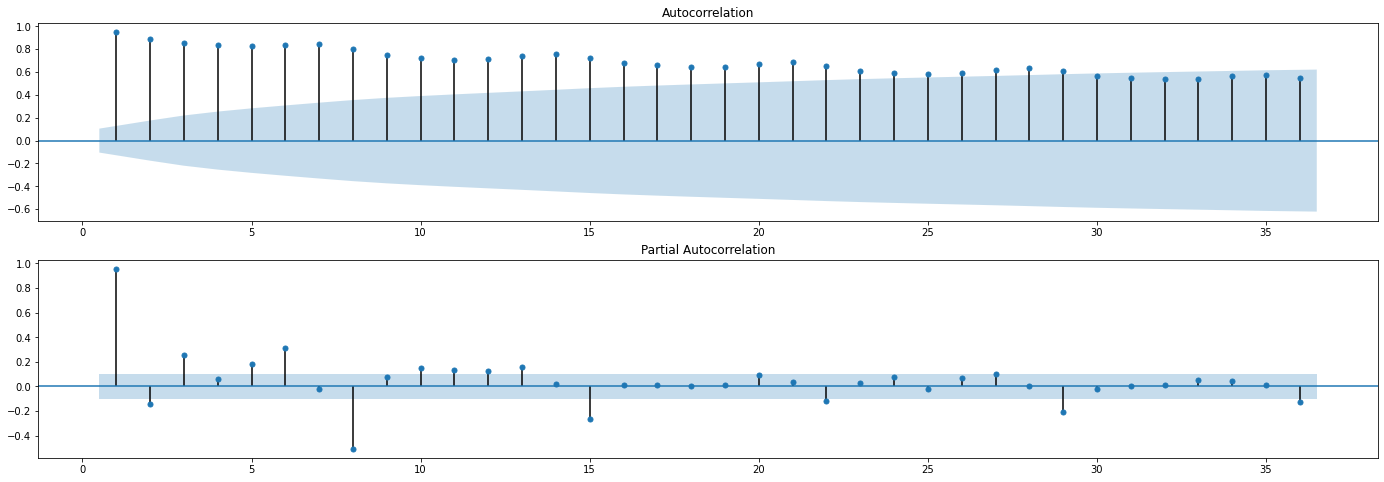

In [38]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.api import qqplot

r,q,p = sm.tsa.acf(calendar_day['price'], fft=True, qstat=True, nlags=36)
r2 = sm.tsa.pacf(calendar_day['price'], nlags=36)
data = np.c_[range(1,37), r[1:], r2[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "PAC", "Q", "Prob"])
print(table.set_index('lag'))

fig = plt.figure(figsize=(24,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(calendar_day['price'], lags=36, ax=ax1, zero=False)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(calendar_day['price'], lags=36, ax=ax2, zero=False)

plt.show()

In [39]:
first_level = [0]
for i in range(len(calendar_day['price'])):
    if i > 0:
        first_level.append(calendar_day['price'][i] - calendar_day['price'][i-1])

calendar_day['frst_lvl_dff'] = first_level

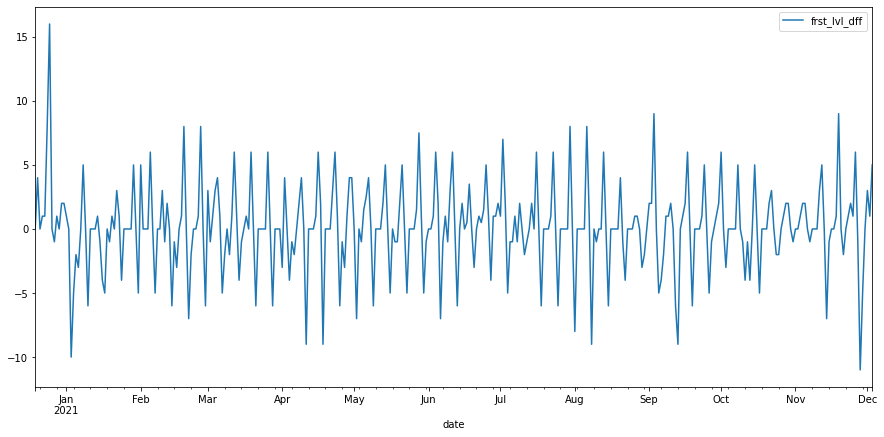

In [40]:
calendar_day[['frst_lvl_dff']].plot(figsize=(15, 7))
plt.show()

In [41]:
adfTest(calendar_day['frst_lvl_dff'])

H0: Data is non-stationary
Ha: Data is stationary 

ADF Statistic/ Test Statistic: -5.289343
p-value: 0.000006
No. of lags: 13
Num of obs: 336
Critical Values:
	1%: -3.450, therefore, reject null hypothesis
	5%: -2.870, therefore, reject null hypothesis
	10%: -2.571, therefore, reject null hypothesis

For a 5% critical value, the data is Stationary


In [42]:
globVSloc(calendar_day['frst_lvl_dff'])

Global Mean: 0.13
Global Standard Deviation: 3.33
Number of Samples: 183.00
Local Mean: 0.13

Hypothesis Testing using z

H0: Global Mean == Local Mean
Ha: Global Mean != Local Mean
Two-tailed Test
Confidence Level: 0.95
z range: -1.63 --- 1.63
z score is:  0.02208499447449765
Therefore, Fail to reject H0
Data is: Stationary


            AC       PAC            Q           Prob
lag                                                 
1.0   0.178654  0.179166    11.267061   7.889452e-04
2.0  -0.303147 -0.348166    43.801141   3.081080e-10
3.0  -0.144599 -0.011552    51.224738   4.381392e-11
4.0  -0.155954 -0.266146    59.884915   3.066979e-12
5.0  -0.284986 -0.319499    88.887571   1.150702e-17
6.0   0.116740  0.115123    93.768355   4.988888e-18
7.0   0.696131  0.594917   267.828327   4.420081e-54
8.0   0.102151 -0.195532   271.587318   4.525637e-54
9.0  -0.328331 -0.114968   310.534896   1.517672e-61
10.0 -0.201345 -0.181531   325.224598   7.137177e-64
11.0 -0.161994 -0.054118   334.761525   4.046128e-65
12.0 -0.280935 -0.163787   363.529336   1.954426e-70
13.0  0.099480  0.014956   367.147212   1.904886e-70
14.0  0.681715  0.332502   537.550094  1.002880e-105
15.0  0.103936 -0.120858   541.522936  9.119756e-106
16.0 -0.300451  0.024272   574.820453  4.978283e-112
17.0 -0.171138 -0.058340   585.656216  1.54881

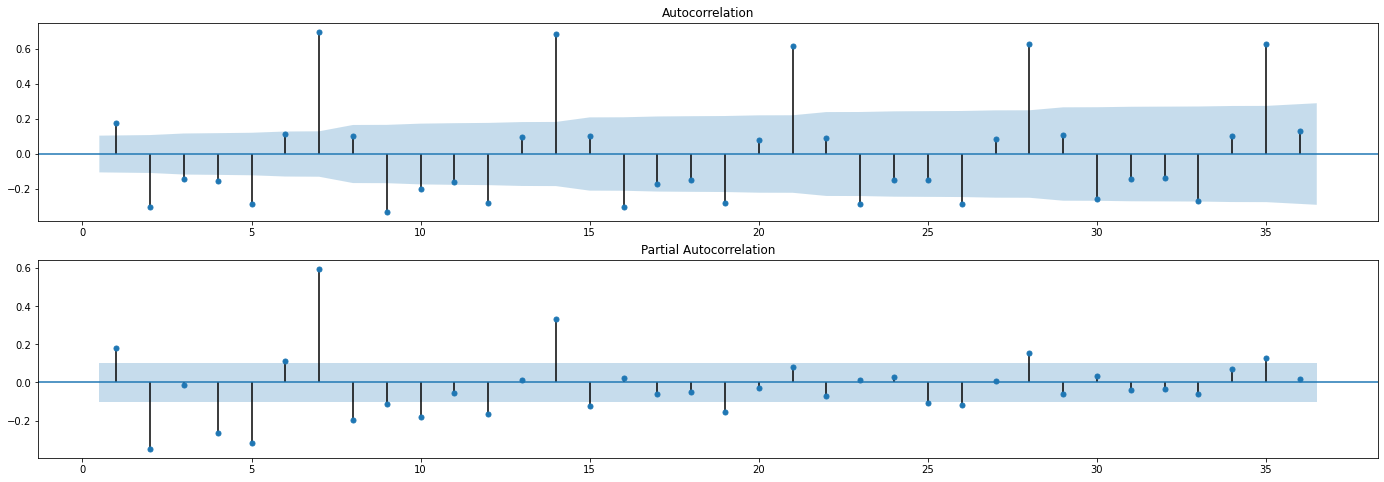

In [43]:
r,q,p = sm.tsa.acf(calendar_day['frst_lvl_dff'], fft=True, qstat=True, nlags=36)
r2 = sm.tsa.pacf(calendar_day['frst_lvl_dff'], nlags=36)
data = np.c_[range(1,37), r[1:], r2[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "PAC", "Q", "Prob"])
print(table.set_index('lag'))

fig = plt.figure(figsize=(24,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(calendar_day['frst_lvl_dff'], lags=36, ax=ax1, zero=False)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(calendar_day['frst_lvl_dff'], lags=36, ax=ax2, zero=False)

plt.show()

In [44]:
import warnings
import itertools
warnings.filterwarnings("ignore")

In [45]:
p = [1,2,4,5] # AR = PCF
d = [1] # diffrence
q = [1,2,3,4] # MA = ACF
pdq = list(itertools.product(p, d, q))
print('Examples of parameter combinations for ARIMA...')
print('ARIMA: {}'.format(pdq[1]))
print('ARIMA: {}'.format(pdq[1]))
print('ARIMA: {}'.format(pdq[2]))
print('ARIMA: {}'.format(pdq[2]))

Examples of parameter combinations for ARIMA...
ARIMA: (1, 1, 2)
ARIMA: (1, 1, 2)
ARIMA: (1, 1, 3)
ARIMA: (1, 1, 3)


In [46]:
aic_list = []
bic_list = []
hqic_list = []
pdq_models = []
from statsmodels.tsa.arima_model import ARIMA
for param in pdq:
    try:
        mod = ARIMA(calendar_day['frst_lvl_dff'], order=param)
        results = mod.fit()
        # AIC - Aikake, BIC - schwarz criterion, HQIC - Hannan-Quinn
        print('ARIMA{}\tAIC:{:,}\t BIC:{:,}\t HQIC:{:,}'.format(param, round(results.aic, 2), round(results.bic, 2), round(results.hqic, 2)))
        pdq_models.append(param)
        aic_list.append(results.aic)
        bic_list.append(results.bic)
        hqic_list.append(results.hqic)
    except:
        continue

ARIMA(1, 1, 1)	AIC:1,831.78	 BIC:1,847.2	 HQIC:1,837.92
ARIMA(1, 1, 3)	AIC:1,775.85	 BIC:1,798.98	 HQIC:1,785.05
ARIMA(2, 1, 1)	AIC:1,789.59	 BIC:1,808.86	 HQIC:1,797.26
ARIMA(2, 1, 2)	AIC:1,791.59	 BIC:1,814.72	 HQIC:1,800.8
ARIMA(2, 1, 3)	AIC:1,746.73	 BIC:1,773.72	 HQIC:1,757.47
ARIMA(4, 1, 1)	AIC:1,768.16	 BIC:1,795.15	 HQIC:1,778.91
ARIMA(4, 1, 2)	AIC:1,758.48	 BIC:1,789.32	 HQIC:1,770.76
ARIMA(4, 1, 3)	AIC:1,657.81	 BIC:1,692.51	 HQIC:1,671.62
ARIMA(5, 1, 1)	AIC:1,704.56	 BIC:1,735.4	 HQIC:1,716.84
ARIMA(5, 1, 2)	AIC:1,620.98	 BIC:1,655.67	 HQIC:1,634.79
ARIMA(5, 1, 3)	AIC:1,617.34	 BIC:1,655.89	 HQIC:1,632.69
ARIMA(5, 1, 4)	AIC:1,585.73	 BIC:1,628.14	 HQIC:1,602.61


In [47]:
print('ARIMA model with lowest AIC', pdq_models[aic_list.index(min(aic_list))])
print('ARIMA model with lowest BIC', pdq_models[bic_list.index(min(bic_list))])
print('ARIMA model with lowest HQIC', pdq_models[hqic_list.index(min(hqic_list))])

ARIMA model with lowest AIC (5, 1, 4)
ARIMA model with lowest BIC (5, 1, 4)
ARIMA model with lowest HQIC (5, 1, 4)


In [48]:
mod514 = ARIMA(calendar_day['price'], order=(5, 1, 4))
arima514 = mod514.fit()

In [49]:
# Save Model to pickle
arima514.save('arima514.pkl')

In [50]:
arima514.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.price   No. Observations:                  349
Model:                 ARIMA(5, 1, 4)   Log Likelihood                -740.375
Method:                       css-mle   S.D. of innovations              1.963
Date:                Thu, 09 Dec 2021   AIC                           1502.749
Time:                        13:49:24   BIC                           1545.155
Sample:                    12-20-2020   HQIC                          1519.630
                         - 12-03-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1260      0.107      1.178      0.240      -0.084       0.336
ar.L1.D.price     0.8115        nan        nan        nan         nan         nan
ar.L2.D.price    -1.4534        nan        nan        nan         nan         nan
ar.L3.D.price     0.8154        nan        nan        nan         nan         nan
ar.L4.D.price    -1.0070      0.000  -3576.898      0.000      -1.008      -1.006
ar.L5.D.price     0.0088      0.000     21.131      0.000       0.008       0.010
ma.L1.D.price    -0.7903      0.016    -48.470      0.000      -0.822      -0.758
ma.L2.D.price     1.4399        nan        nan        nan         nan         nan
ma.L3.D.price    -0.7894        nan        nan        nan         nan         nan
ma.L4.D.price     0.9983        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2220           -0.9751j            1.0000           -0.2856
AR.2           -0.2220           +0.9751j            1.0000            0.2856
AR.3            0.6234           -0.7819j            1.0000           -0.1429
AR.4            0.6234           +0.7819j            1.0000            0.1429
AR.5          114.0350           -0.0000j          114.0350           -0.0000
MA.1            0.6207           -0.7845j            1.0004           -0.1435
MA.2            0.6207           +0.7845j            1.0004            0.1435
MA.3           -0.2253           -0.9748j            1.0005           -0.2862
MA.4           -0.2253           +0.9748j            1.0005            0.2862
-----------------------------------------------------------------------------
"""

In [51]:
# Make Predictions until 2025
arima514_pred = arima514.predict("2020-12-27", "2022", typ='levels')

# Get Confidence Intervals of the new unobserved dates
arima514_conf_int = pd.DataFrame(arima514.forecast(34)[2], columns=['min', 'max'])
arima514_conf_int.index = arima514_pred.index[337:]

            AC       PAC           Q          Prob
lag                                               
1.0   0.051091  0.051238    0.918853  3.377764e-01
2.0   0.082600  0.080662    3.327444  1.894326e-01
3.0   0.069881  0.063015    5.056366  1.677160e-01
4.0   0.012142 -0.000368    5.108712  2.763238e-01
5.0   0.144863  0.137551   12.581561  2.763200e-02
6.0  -0.101567 -0.124556   16.265773  1.239636e-02
7.0   0.152760  0.152735   24.624209  8.843862e-04
8.0  -0.173805 -0.214657   35.475988  2.189429e-05
9.0  -0.018203  0.013837   35.595372  4.676480e-05
10.0 -0.132061 -0.180620   41.897458  7.820339e-06
11.0 -0.064994  0.034950   43.428417  9.145667e-06
12.0  0.074136  0.026035   45.426268  8.708290e-06
13.0 -0.147287 -0.043708   53.335289  7.899979e-07
14.0  0.156907  0.134183   62.338026  4.545532e-08
15.0 -0.153960 -0.113971   71.031618  2.924036e-09
16.0  0.036682  0.038842   71.526594  5.383270e-09
17.0 -0.055663 -0.093734   72.669816  7.447135e-09
18.0 -0.019676  0.029911   72.8

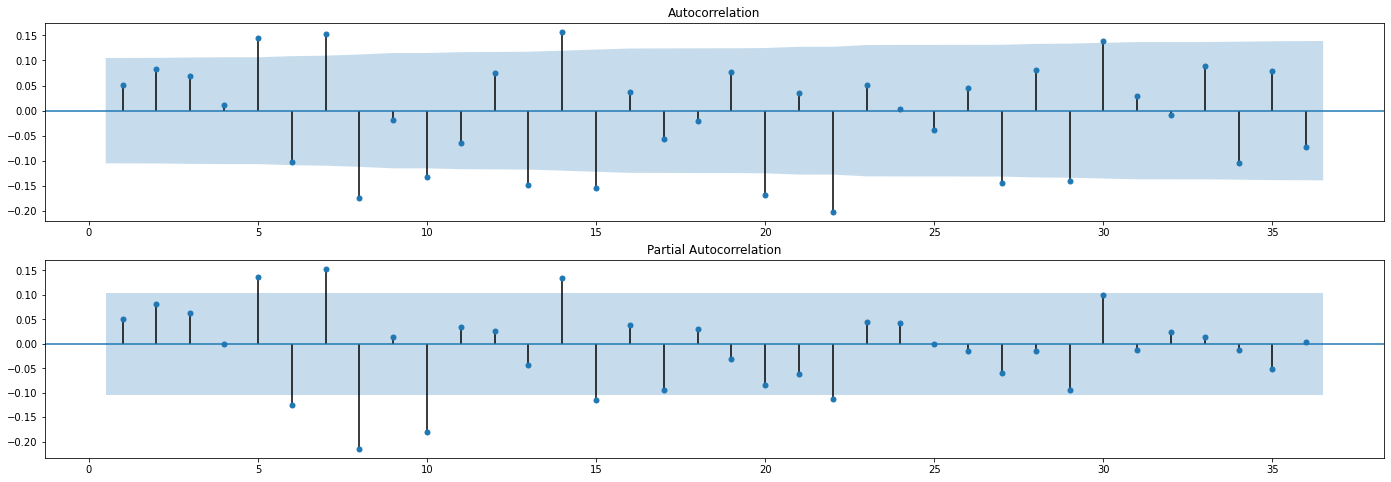

In [52]:
# Check Residuals
resid = arima514.resid
r,q,p = sm.tsa.acf(resid, fft=True, qstat=True, nlags=36)
r2 = sm.tsa.pacf(resid, nlags=36)
data = np.c_[range(1,37), r[1:], r2[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "PAC", "Q", "Prob"])
print(table.set_index('lag'))

fig = plt.figure(figsize=(24,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid, lags=36, ax=ax1, zero=False)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=36, ax=ax2, zero=False)

In [53]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(calendar_day['price'][1:350], arima514_pred[:349]))
print('Test RMSE: {:,.3f}'.format(rmse))

Test RMSE: 5.013


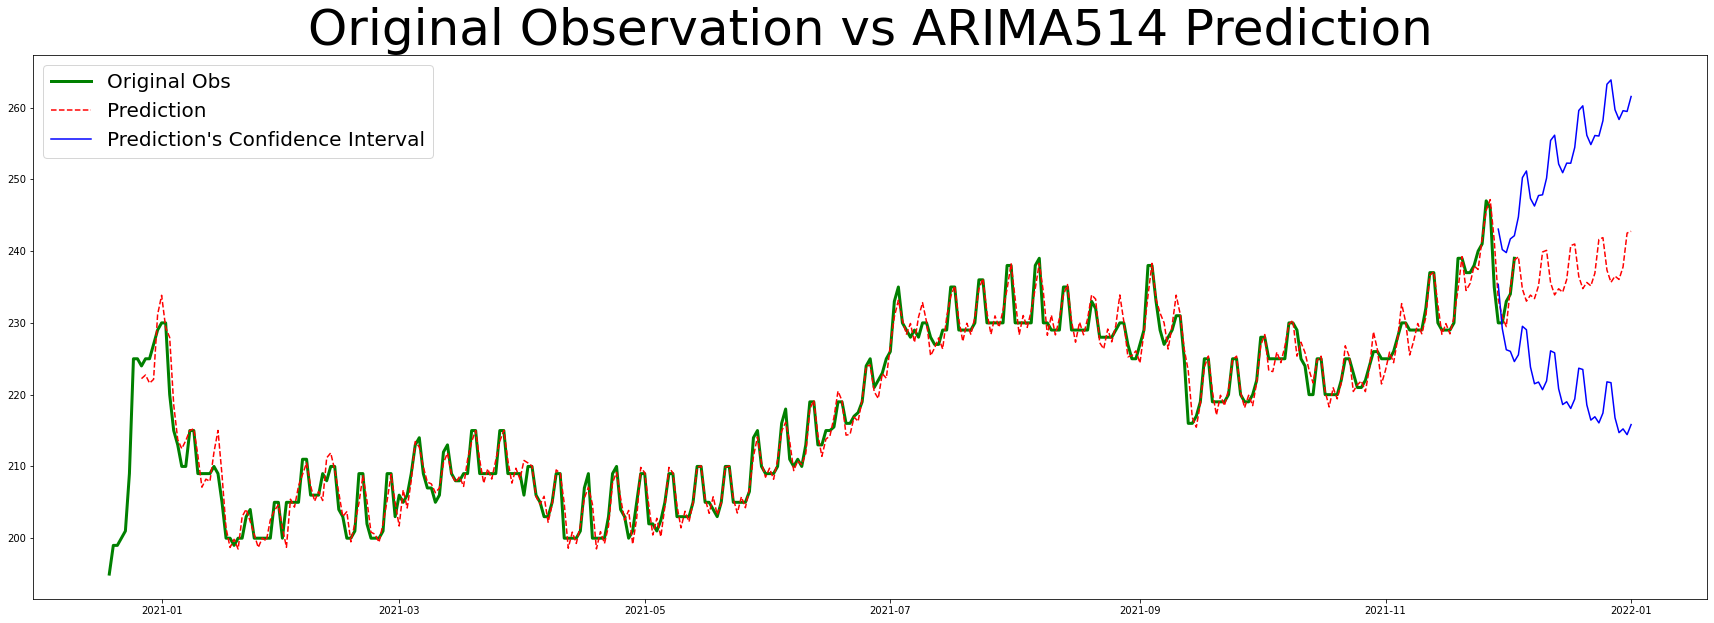

In [54]:
fig, ax = plt.subplots(figsize=(30,10))
plt.title('Original Observation vs ARIMA514 Prediction', {'fontsize': 50})
plt.plot(calendar_day['price'], label='Original Obs', color='green', linewidth=3)
plt.plot(arima514_pred, label='Prediction', color='red', linestyle='dashed')
plt.plot(arima514_conf_int['min'], label='Prediction\'s Confidence Interval', color='blue')
plt.plot(arima514_conf_int['max'], color='blue')
plt.legend(prop={'size': 20})
plt.show()